ENPM-673 Project 2
~~~
PART-1
~~~



This section imports the needed libraries and then it setsGoogle Colab environment to access files from Google Drive and imports the cv2_imshow() function casue the cv2.inshow() does not work in these notebooks.






In [1]:
#import all necessary library
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

#mount google drive to take the video to be processed
from google.colab import drive
drive.mount('/content/drive')
#importing cv2_imshow function
from google.colab.patches import cv2_imshow

Mounted at /content/drive


This section locates and imports the video file into the colab and throws an error message if the video is not opened


In [ ]:

#read the file and see if its able to open the video
file = "/media/proj2_v2.mp4"
cap = cv2.VideoCapture(file)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()


This section of code sets the necessary variables needed

In [ ]:
extracted_frames=[]#list for extracted frame
unblur_frames=[]#list for gettting unblur frames
blur_frames=[]#list for blur frame
frame_w_line = []#list for getting the final output frame
threshold = 110#threshold value for checking the blur frames
blurry_frame_count = 0#appends the blur frame count

This cell reads the frames in video and appends it in a list


In [ ]:
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #get the total frames in the video

#read each frame and append the extracted frames
for frame_count in range(1, total_frames + 1):
    ret, frame = cap.read()

    if not ret:
        break
    extracted_frames.append(frame)

This cell defines a kernel for variance of laplacian to check if the image is blur


In [ ]:
def variance_of_laplacian(image):
    #to manually apply the laplacian kernel reffered for documentation
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])#define the laplacian kernel
    laplacian = cv2.filter2D(image, cv2.CV_64F, laplacian_kernel)#get the laplacian value
    return laplacian.var()#return its variance to compare with threshold value



This cell checks if the frames are blur and appends blur and unblur frames


In [ ]:
for fra in extracted_frames:
  gray = cv2.cvtColor(fra, cv2.COLOR_BGR2GRAY)#convert to grayscale to process the frame
  if variance_of_laplacian(gray) < threshold:#check if its below the threshold value
    blurry_frame_count += 1 #get the blur frame count
    blur_frames.append(fra)
    # print(blurry_frame_count)
    continue
  else:
    unblur_frames.append(fra)

As given in the announcement, this cell checks and tells the percentage of frames which are unblur. Here it is 52% which is more than half of the total number of frames as mentioned


In [ ]:
perce = len(unblur_frames)
tage = (perce/total_frames)*100
print("Percentage of unblur frame = ", tage,"%")

Percentage of unblur frame =  52.07253886010362 %


This cell is to check the shaoe of the frame since to append the frames in a video, we need the shape of the frame

In [ ]:
s_frame = unblur_frames[20]
w,h = s_frame.shape[:2]#get the shape of the imahge
# print(h , w)

This function segment_white_regions, is designed to isolate and segment the white regions from an input image

In [ ]:
def segment_white_regions(image):
    #convert to grayscale if the image is in color since we need a single layer here
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    #to keep only white regions we apply thresholding
    _, thresholded = cv2.threshold(gray, 208, 255, cv2.THRESH_BINARY)

    #we mask the threshold image to get the segmented image
    segmented = cv2.bitwise_and(gray, gray, mask=thresholded)
    return segmented

The detect_and_filter_lines function converts a grayscale image to BGR color space, then uses the Canny edge detector to identify edges within the image. and detects and returns lines in the image

In [ ]:
def detect_and_filter_lines(image):
    #convert to a BGR image for colored line drawing if it's not already
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    edges = cv2.Canny(image, 50, 200, apertureSize=3)#get the edge using canny edge
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 10, minLineLength=110, maxLineGap=10)#probabilistic Hough line transform is used to detect and return lines in the image
    return lines

This filter_short_lines function takes a list of line and minimum length as inputs and filters out short line compaing with specified minimum length. It calculates the length using the euclidean distance formula and if the length exceeds the minimum length, it's added to the list






In [ ]:
def filter_short_lines(lines, min_length):
    if lines is None:#check is there are any values
        return []
    filtered_lines = []#create the list
    for line in lines:#iterate and finf the lines
        for x1, y1, x2, y2 in line:
            if np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) > min_length:
                filtered_lines.append(line)
    return filtered_lines#returns teh lines which are above min length

This function calculates the intersection point of two lines. It then calculates the determinant d to check if the lines are parallel (if d is 0). If the lines are not parallel, it calculates the intersection point's x and y using the formula derived from the equation. If the lines intersect, it returns the intersection point (x, y)

In [ ]:
def line_inter(line1, line2):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]

    d = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)#check if it is intersecting
    if d:
        x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / d
        y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / d
        return (x, y)#retuirns the intersecting point as (x,y)
    else:
        return None

The find_intersections identifies all the intersection points among a set of lines. It iterates through all the lines and calls the line_intersection function to find it. If an intersection exists, it is added to the intersections list and then it returns it

In [ ]:
def find_intersections(lines):
    inter = []# create a list to append the intersecting values
    for i, line1 in enumerate(lines):
        for line2 in lines[i+1:]:
            inter = line_inter(line1, line2) #get the value dof the intersecting points
            if inter:#if it dosent return none, append it
                inter.append(inter)
    return inter

The function in this cell filters intersection points to ensure they correspond to actual corners as asked in the guidelines. It first applies the Harris corner to find corners in the image and they are then dilated a littel to enhance their visibility. The function iterates through the intersection points and checks if its within the image bound. If both are true then the intersection is considered valid and appened and returned back






In [ ]:
def validate_intersections(intersections, gray_image):
    corners = cv2.cornerHarris(gray_image, 2, 3, 0.04)#get the cornors using Harris methdod
    corners = cv2.dilate(corners, None)#dilate to make it more clear

    valid_intersections = []#create an enpty list to store values
    for x, y in intersections:#iterate and check if the points found are within the region
        if 0 <= int(y) < corners.shape[0] and 0 <= int(x) < corners.shape[1]:
            if corners[int(y), int(x)] > 0.01 * corners.max():
                valid_intersections.append((x, y))
    return valid_intersections

In [ ]:
# def verify_corners(image, corners):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     corners = cv2.cornerHarris(gray, 2, 3, 0.04)
#     return np.argwhere(corners > corners.max() * 0.01)

This cell identifies the extreme points among a given set of points which are the points with the minimum and maximum x-coordinates and the points with the minimum and maximum y-coordinates which can be said to be the extreme points. It then returns these points in a list

In [ ]:
def get_extreme_points(points):
    min_x = min(points, key=lambda point: point[0])#gets the minimum x
    max_x = max(points, key=lambda point: point[0])#gets the maximum x
    min_y = min(points, key=lambda point: point[1])#gets the minimum y
    max_y = max(points, key=lambda point: point[1])#gets the maximum y

    return [min_x, max_x, min_y, max_y]

This code block is the main block which uses all the functions and processes a sequence of video frames to detect and get the lines and the coroners. first, it converts each frame to grayscale and segments the white region and it detects and filters lines within these regions. For frames with valid lines, it draws these lines in blue, finds their intersections, and validates these intersections using Harris corner detection. Valid intersections are considered extreme points and are marked with red circles. Finally, the processed frame is added to a list to create a video as asked







In [ ]:
for frame in unblur_frames:
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)#convert to gray for validation
    white_frame = segment_white_regions(frame)#segment the white refuon from theh unblur frames
    line_frame = detect_and_filter_lines(white_frame)#detect the lines frm the franes segmented
    lines_filtered = filter_short_lines(line_frame, 110)#get the filtered lines to draw
    if lines_filtered is not None:
        for line in lines_filtered:#iteerate through the corodinates and draw some lines in color mentioned
            for x1, y1, x2, y2 in line:
                cv2.line(frame, (x1, y1), (x2, y2), (225, 0, 0), 3)#blue lines
    intersections = find_intersections(lines_filtered)#find intersections of the lines
    valid_intersections = validate_intersections(intersections, gray_frame)#validate intersections using Harris corner detection
    if valid_intersections:  #proceed only if there are valid intersections
        corners = get_extreme_points(valid_intersections)
        #draw the validated intersections as circles on the frame
        for point in valid_intersections:
            x, y = point
            cv2.circle(frame, (int(x), (int(y))), 5, (0, 0, 255), -1)#red circles

    frame_w_line.append(frame)#append the final frames to make as a video

This cell creates a video writer and appends all the frames that are processed in a mp4 format

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  #define the format of the video
out = cv2.VideoWriter('/media/harshav_project3.mp4', fourcc, 10.0, (720, 960)) #crearte the video write and the name with the correct shape

#write the frames to the video
for frame in frame_w_line:
    out.write(frame)
#releaase after completing
out.release()


~~~
PART-2.1

~~~


This cell imports the necessary libraries such as cv2, numpy and matplot


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

This code block gets the image from the drive and reads that and converts to grayscale for further processing

In [ ]:
image_files = ["/media/PA120272.JPG","/media/PA120273.JPG" ,
               "/media/PA120274.JPG", "/media/PA120275.JPG"]#get all the image from the drive
images = [cv2.imread(image) for image in image_files] #read the images and save it in images
img_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]#convert all the images to grayscale

The code initializes a SIFT feature extractor, it iterates over grayscale images generated before to detect keypoints and compute descriptors for each image, and stores these keypoints and descriptors in seperate lists.

In [ ]:
sift = cv2.SIFT_create()#initalizse the SIFT feature extracter
keyp = []#empty list for storing the keypoints
descri = []#empty list to store teh drscriptors
for img_g in img_gray:
    kp, desc = sift.detectAndCompute(img_g, None)#get the keypoints and descriptors from the image
    keyp.append(kp)
    descri.append(desc)

This code block uses FLANN (Fast Library for Approximate Nearest Neighbors) based matcher to find matches between features in consecutive images using SIFT descriptors. It specifies parameters for the FLANN indexer and searcher. Then, it iteratively matches the descriptors from each image with the next one in the sequence using the k-nearest neighbors method, where k is set to 2. These matches are stored in the matches list which is then further processed








In [ ]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)  #define index parameters
search_params = dict(checks=50) #define search parameters
flann = cv2.FlannBasedMatcher(index_params, search_params)#initialize the FLANN based matcher
matches = []# create an empty list to store matches between consecutive images
for i in range(len(descri) - 1):
    matches.append(flann.knnMatch(descri[i], descri[i + 1], k=2))#perform k-nearest neighbor where k=2



This code block retains only the "good" matches based on a ratio test. For each pair of matches (m, n), if the distance of the first match m is less than 0.7 times the distance of the second match n, it indicates that m is a reliable match and is added to the good list. This process is repeated and the resulting good matches for each image pair stored in the good_matches list. This eliminates false matches and improves the accuracy of feature matching.

In [ ]:
good_matches = []#create empty list to store list of good matches
for match in matches:
    good = []#initialize an empty list to store good matches
    for m, n in match:
        if m.distance < 0.7 * n.distance:#apply the ratio test
            good.append(m)  #add the good match to the list
    good_matches.append(good)#append the list of good matches


This part of the code computes the homography matrices between pairs of consecutive images using the good matches identified earlier. For each pair of images, it extracts the source (src_pts) and destination (dst_pts) points from the keypoints associated with the good matches. And cv2.findHomography function is used to find the homographic martrix, employing the RANSAC algorithm to estimate the transformation. The computed matrices are stored in the homographies list.

In [ ]:
homograph = []#create an empty list to store homography matrices
for i, match in enumerate(good_matches):
    src_pts = np.float32([keyp[i][m.queryIdx].pt for m in match]).reshape(-1,1,2)#extract source points
    dst_pts = np.float32([keyp[i+1][m.trainIdx].pt for m in match]).reshape(-1,1,2)#extract destination points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)#compute the homography matrix
    homograph.append(M)#append the homography matrix



This secion below stitches the images together using the previously computed homography matrices. It initializes the output_image with the first image and iteratively warps each subsequent image to align with the previous one. The cv2.warpPerspective function applies the corresponding homography matrix to transform the output_image to the perspective of the next image, effectively expanding the output_image to accommodate the new image. Then, it places the next image onto the transformed output_image. The result is a progressively stitched panorama or a composite image where each subsequent image is aligned and overlaid with the previous ones. I tried to creart a correct panaroma as you said to optimize further, but I had another submission today and had to go to court so could'nt work on it

In [ ]:
#initialize the first image as the base
output_image = images[0]
#loop through the remaining images to stitch them together
for i in range(1, len(images)):
    h, w, _ = output_image.shape#get the current height and width of this imahge
    output_image = cv2.warpPerspective(output_image, homograph[i-1], (w*2, h))#apply the homography transformation
    output_image[0:images[i].shape[0], 0:images[i].shape[1]] = images[i]#overlay the next image onto the transformed output image


The below code crops the black areas, which typically represent unused or invalid regions and converts the output_image to grayscale and then applies a binary threshold to create a mask (thresh) where non-black areas are set to white and black areas to black. By finding the external contours in this binary mask, the code identifies the boundaries of the non-black regions, which can be used to define the cropping rectangle for removing the surrounding black areas.

In [ ]:
gray_output = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)#convert the stitched image to grayscale
_, thresh = cv2.threshold(gray_output, 1, 255, cv2.THRESH_BINARY)#apply mask such that non-black areas are white and black areas are black
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#find the external contours to identify the non-black regions


This block iterates through the contours and calculates the bounding rectangle using cv2.boundingRect and computes its area by multiplying width and height . If the area of the current rectangle is larger than the previously recorded maximum area (max_area), the code then updates max_area and best_rect with the new values. After completing the iteration, best_rect holds the coordinates and size of the largest bounding rectangle

In [ ]:
#initialize variable
max_area = 0#large area variable
best_rect = (0, 0, 0, 0)#best rectangel vairable


for cnt in contours:#iterate through each contour
    x, y, w, h = cv2.boundingRect(cnt)#calculate the bounding rectangle
    #check if the area of this rectangle is greater than the maximum area found so far
    if w * h > max_area:
        max_area = w * h  #if so update the maximum area
        best_rect = (x, y, w, h)  #also update the best rectangle


This code uses the coordinates and dimensions of the largest bounding rectangle found in the previous step which has the variables x, y, w, and h which all define the top-left corner and size of the rectangle. The output_image is then cropped to these dimensions, resulting in the panorama without the unnecessary black margins surrounding it

In [ ]:
x, y, w, h = best_rect#extract the x, y and width, height
panorama = output_image[y:y+h, x:x+w]#crop the output image to get final panorama



This section of code block converts the image to color from grayscale and displays the image using matplot

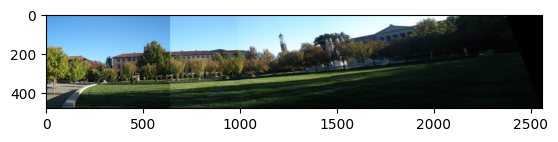

In [ ]:
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))#convert bgr to rgb
plt.show()#display the panaroma


~~~
PART-2.2
~~~~

By limiting rotation to the center of the camera, panoramic mosaicing minimizes parallax error, which results from the apparent movement of objects when viewed from different vantage points. Each image is captured from the same viewpoint as the camera rotates around its center, preserving the relative positions of objects within the scene. A panorama can only be created accurately if images are stitched together consistently. It is easier to calculate the transformations needed to stitch consecutive images together smoothly when there is little or no parallax between the overlapping regions of the images. In the event that the camera translates (moves sideways, up, down, forward and backward) during capture, the resulting parallax can result in misalignments that can be difficult to correct during stitching, leading to visible seams, distortions, or ghosting effects. In order to minimize these issues and achieve a high-quality panoramic mosaic, rotation of the camera around its center is preferred.